In [10]:
import torch 
from torch import nn
import yfinance as yf
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

In [11]:
class VAEDataDownloader:
    
    def __init__(self, tickers, train_size, window_size):
        self.train_size = train_size
        self.tickers = tickers
        self.window_size = window_size
        self.train_dict = {}
        self.test_dict = {}
        
        print('Start downloading data from yfinance...')
        for ticker in tqdm(self.tickers):
            result = self.download_data(ticker)
            if result is not None:
                self.train_dict[ticker] = dict()
                self.test_dict[ticker] = dict()
                self.train_dict[ticker]['data'] = result[0]
                self.test_dict[ticker]['data'] = result[1]
            
    def download_data(self, ticker):
        array = list(yf.Ticker(ticker).history(period="max")['Close'].dropna())
        train, test = self.train_test_split(array)
        if len(train) < self.window_size + 1 or len(test) < self.window_size + 1:
            return None
        return train, test
    
    def train_test_split(self, array):
        train = array[:int(len(array)*self.train_size)]
        test = array[int(len(array)*self.train_size):]
        return train, test

In [12]:
class VAEDataset(torch.utils.data.Dataset):
    
    def __init__(self, tickers_to_data, window_size):
        self.tickers_to_data = tickers_to_data
        self.window_size = window_size
        self.total_length = 0
        self.get_total_length()
        
    def get_total_length(self):
        left = 0
        right = 0
        for ticker in self.tickers_to_data.keys():
            array_len = len(self.tickers_to_data[ticker]['data'])
            elements = array_len - self.window_size
            self.total_length += elements
            right = left + elements
            self.tickers_to_data[ticker]['left'] = left
            self.tickers_to_data[ticker]['right'] = right
            left = right
    
    def prepare_element(self, time_series):
        x = [1]
        time_series = np.array(time_series)
        pct = time_series[:-1]/time_series[1:] - 1
        for el in pct:
            x.append(x[-1]*(el + 1))
        while len(x) != self.window_size:
            if len(x) > self.window_size:
                x.pop()
            else:
                x.append(x[-1])
        return torch.Tensor(x)
    
    def __getitem__(self, ind):
        for ticker in self.tickers_to_data.keys():
            if ind >= self.tickers_to_data[ticker]['left'] and ind <= self.tickers_to_data[ticker]['right']:
                ind = ind - self.tickers_to_data[ticker]['left'] 
                return self.prepare_element(self.tickers_to_data[ticker]['data'][ind:ind+self.window_size])
    
    def __len__(self):
        return self.total_length

In [13]:
class VAEModel(nn.Module):
    
    def __init__(self, window_size):
        super(VAEModel, self).__init__()
        self.window_size = window_size
        self.encoder = nn.Sequential(nn.Linear(self.window_size, 128), 
                                    nn.ReLU(), 
                                    nn.Linear(128, 64), 
                                    nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(64, 128), 
                                    nn.ReLU(), 
                                    nn.Linear(128, self.window_size))
    
    def forward(self, x):
        return self.decoder(self.encoder(x))
    
    def get_embedding(self, x):
        with torch.no_grad():
            return self.encoder(x)

In [14]:
class Trainer:
    
    def __init__(self, tickers, 
                 window_size = 255, 
                 train_size = 0.75, 
                 lr = 0.001, 
                 batch_size = 64, 
                 lambda_coef = 0.00007):
        
        self.window_size = window_size
        self.train_size = train_size
        self.tickers = tickers
        self.lambda_coef = lambda_coef
        self.batch_size = batch_size
        self.lr = lr
        self.model_name = 'Linear_VAE.pytorch'
        self.best_model = None
        
        self.criterion = nn.L1Loss()
        print('Download data...')
        self.loader = VAEDataDownloader(self.tickers, self.train_size, self.window_size)
        print('Making datasets...')
        self.train_dataset = VAEDataset(self.loader.train_dict, self.window_size)
        self.test_dataset = VAEDataset(self.loader.test_dict, self.window_size)
        print('Making dataloaders...')
        self.train_dataloader = torch.utils.data.DataLoader(self.train_dataset, batch_size = self.batch_size)
        self.test_dataloader = torch.utils.data.DataLoader(self.test_dataset, batch_size = self.batch_size)
        print("Number of elements in train dataset : "+str(len(self.train_dataset)))
        print("Number of elements in test dataset : "+str(len(self.test_dataset)))
        print("\nNumber of batches in train dataset : "+str(len(self.train_dataset)//self.batch_size + 1))
        print("Number of batches in tetstt dataset : "+str(len(self.test_dataset)//self.batch_size + 1))
        print('Making model...')
        self.model = VAEModel(self.window_size)
        print('Number of parameters in model : '+str(sum(p.numel() for p in self.model.parameters())))
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = self.lr)
        
        self.train_loss_hist = []
        self.test_loss_hist = []
        
    def get_loss(self, x, y):
        loss = self.criterion(x, y) + self.lambda_coef*torch.sum((y[:,:-1] - y[:,1:])**2)
        return loss
    
    def train_one_epoch(self):
        train_loss_it = 0
        for x in self.train_dataloader:
            self.optimizer.zero_grad()
            y = self.model(x)
            loss = self.get_loss(x, y)
            loss.backward()
            train_loss_it += loss.item()
            self.optimizer.step()
        self.train_loss_hist.append(train_loss_it)
    
    def test_one_epoch(self):
        with torch.no_grad():
            test_loss_it = 0
            for x in self.test_dataloader:
                y = self.model(x)
                loss = self.get_loss(x, y)
                test_loss_it += loss.item()
            self.test_loss_hist.append(test_loss_it)
    
    def save_model(self, load = False):
        torch.save(self.model, self.model_name)
        if load:
            self.best_model = torch.load(self.model_name)
    
    def train(self, number_of_epochs):
        min_test_loss = None
        for epoch in tqdm(range(1, number_of_epochs + 1)):
            self.train_one_epoch()
            if epoch == 1:
                min_test_loss = self.test_loss_hist[-1] if len(self.test_loss_hist) > 0 else 1e10
                self.save_model()
            elif self.test_loss_hist[-1] < min_test_loss:
                min_test_loss = self.test_loss_hist[-1]
                self.save_model()
            self.test_one_epoch()
            
    def plot_loss_hist(self):
        plt.figure(figsize=(12, 7))
        plt.plot(self.train_loss_hist, label = 'train')
        plt.plot(self.test_loss_hist, label = 'test')
        plt.legend()
        plt.grid()
        plt.show()
        
    def plot_model_prediction(self, ind, dataset = 'test', best = False):
        x = None
        if dataset == 'test':
            x = self.test_dataset[ind]
        else:
            x = self.train_dataset[ind]
        y = None
        if best:
            if self.best_model is None:
                self.best_model = torch.load(self.model_name)
            y = self.best_model(x.unsqueeze(dim = 0)).detach().numpy()[0]
        else:
            y = self.model(x.unsqueeze(dim = 0)).detach().numpy()[0]
        plt.figure(figsize=(17, 10))
        plt.plot(x.detach().numpy(), label='x')
        plt.plot(y, label='y')
        plt.legend()
        plt.grid()
        plt.show()
        
        print('std(x) : ' + str(x.std().item()*(255**0.5)))
        print('std(y) : ' + str(np.array(y).std()*(255**0.5)))
        print()
        print('mean(x) : ' + str(x.mean().item()))
        print('mean(y) : ' + str(np.array(y).mean()))

In [15]:
TICKERS = ['MSFT', 'AAPL', 'ADBE', 'ORCL', 'NVDA', 'CSCO', 'CRM', 'INTC', 'AMD']
trainer = Trainer(TICKERS)

  0%|          | 0/9 [00:00<?, ?it/s]

Download data...
Start downloading data from yfinance...


100%|██████████| 9/9 [00:05<00:00,  1.70it/s]

Making datasets...
Making dataloaders...
Number of elements in train dataset : 56803
Number of elements in test dataset : 17410

Number of batches in train dataset : 888
Number of batches in tetstt dataset : 273
Making model...
Number of parameters in model : 82239


In [16]:
trainer.train(12)

100%|██████████| 12/12 [03:01<00:00, 15.16s/it]


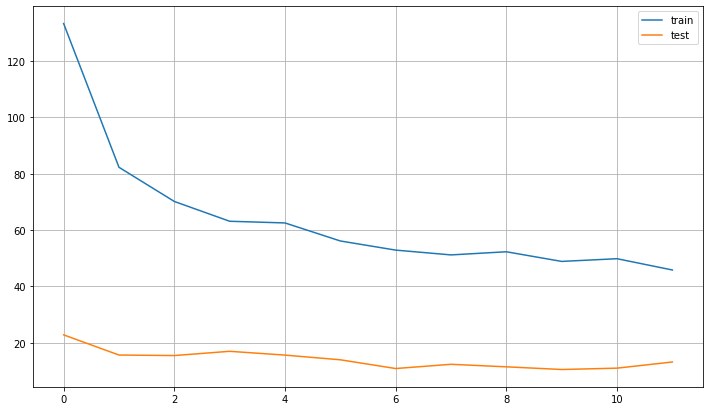

In [17]:
trainer.plot_loss_hist()

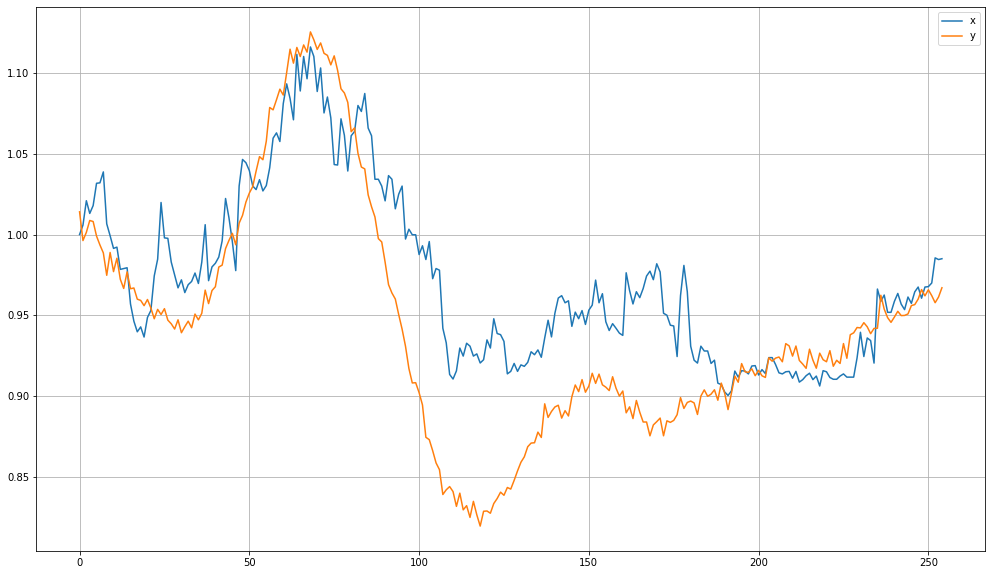

std(x) : 0.8510463206085754
std(y) : 1.1524000860578731

mean(x) : 0.9714999198913574
mean(y) : 0.9436624


In [20]:
trainer.plot_model_prediction(7000)